In [1]:
# from dipy.data import fetch_stanford_hardi
# fetch_stanford_hardi()
from scipy.ndimage import binary_dilation

In [2]:
##### file paths
fidwi  = 'stanford_hardi/HARDI150.nii.gz'
fbval  = 'stanford_hardi/HARDI150.bval'
fbvec  = 'stanford_hardi/HARDI150.bvec'
filab  = 'stanford_hardi/aparc-reduced.nii.gz'
fit1w  = 'stanford_hardi/t1.nii.gz'

In [3]:
from dipy.io.image import load_nifti, load_nifti_data, save_nifti
data, affine, img = load_nifti(fidwi, return_img=True)

In [4]:
data.shape

(81, 106, 76, 160)

In [5]:
# fbval

In [6]:
# affine.shape

In [7]:
# print(img.header.get_zooms()[:3])
# print(img.header.get_zooms()[:3])

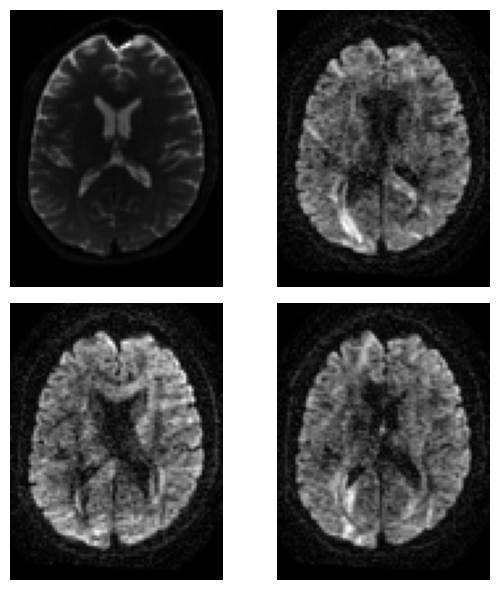

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
axial_middle = data.shape[2] // 2
# plt.figure('Showing the datasets')
plt.subplot(2, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 40].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off()
plt.imshow(data[:, :, axial_middle, 80].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off()
plt.imshow(data[:, :, axial_middle, 120].T, cmap='gray', origin='lower')
plt.tight_layout()
plt.show()
# # plt.savefig('01_visualize.png', bbox_inches='tight')
# plt.savefig('01_visualize.jpg', bbox_inches='tight')

In [9]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

In [10]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [11]:
print(gtab.info)


B-values shape (160,)
         min 0.000000
         max 2000.000000
B-vectors shape (160, 3)
          min -0.999130
          max 0.998710

None


In [12]:
# from dipy.data import get_fnames
# label_fname = get_fnames('stanford_labels')


In [13]:
filab

'stanford_hardi/aparc-reduced.nii.gz'

In [14]:
### load labels
labels = load_nifti_data(filab)

In [15]:
import numpy as np
np.unique(labels.flatten())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86,
       87, 88], dtype=uint8)

In [16]:
white_matter = binary_dilation((labels == 1) | (labels == 2))

# leftright_hippo = (labels == 42) | (labels == 85)

In [17]:
# white_matter

In [18]:
# white_matter.shape, leftright_hippo.shape

In [19]:
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

In [20]:
# response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)

In [21]:
csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, data, default_sphere, relative_peak_threshold=.8, min_separation_angle=45, mask=white_matter)
# csa_peaks = peaks_from_model(csa_model, data, default_sphere, relative_peak_threshold=.8, min_separation_angle=45)
# csa_peaks_lr_hippo = peaks_from_model(csa_model, data, default_sphere, relative_peak_threshold=.8, min_separation_angle=45, mask=leftright_hippo)

In [22]:
# type(csa_peaks_lr_hippo)

In [23]:
#### save csa peaks 
# import dill as pickle

In [24]:
# ## the above step is time taking to we save it to pickle in case we get error later
# import dill as pickle
# with open('csa_peaks.pkl', 'wb') as file:
#     pickle.dump(csa_peaks, file)
    
    

In [25]:
# with open('csa_peaks.pkl', 'rb') as file:
#     csa_peaks = pickle.load(file)

In [26]:
from dipy.viz import window, actor, has_fury

In [27]:
scene = window.Scene()
scene.add(actor.peak_slicer(csa_peaks.peak_dirs, csa_peaks.peak_values, colors=None))
# window.record(scene, out_path='csa_direction_field.png', size=(300, 300))
window.show(scene, size=(900, 900))

In [28]:
# scene = window.Scene()
# scene.add(actor.peak_slicer(csa_peaks_lr_hippo.peak_dirs, csa_peaks_lr_hippo.peak_values, colors=None))
# # window.record(scene, out_path='csa_direction_field.png', size=(300, 300))
# window.show(scene, size=(300, 300))

In [28]:
# # Enables/disables interactive visualization
interactive = True

# if has_fury:
#     scene = window.Scene()
#     scene.add(actor.peak_slicer(csa_peaks.peak_dirs,
#                                 csa_peaks.peak_values,
#                                 colors=None))

#     window.record(scene, out_path='csa_direction_field.png', size=(900, 900))

#     if interactive:
#         window.show(scene, size=(800, 800))

In [29]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, .50)

In [30]:
# import matplotlib.pyplot as plt

# sli = csa_peaks.gfa.shape[2] // 2
# plt.figure('GFA')
# plt.subplot(1, 2, 1).set_axis_off()
# plt.imshow(csa_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')

# plt.subplot(1, 2, 2).set_axis_off()
# plt.imshow((csa_peaks.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')

# # plt.savefig('gfa_tracking_mask.png')

In [31]:
# import matplotlib.pyplot as plt

# sli = csa_peaks.gfa.shape[2] // 2
# plt.figure('GFA')
# plt.subplot(1, 2, 1).set_axis_off()
# plt.imshow(csa_peaks_lr_hippo.gfa[:, :, sli].T, cmap='gray', origin='lower')

# plt.subplot(1, 2, 2).set_axis_off()
# plt.imshow((csa_peaks_lr_hippo.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')

# # plt.savefig('gfa_tracking_mask.png')

In [57]:
from dipy.tracking import utils

# seed_mask = (labels == 1) #["Left-Cerebral-White-Matter","Right-Cerebral-White-Matter", "WM-hypointensities", "Optic-Chiasm", "ctx-lh-corpuscallosum", "ctx-rh-corpuscallosum" 
# seed_mask = (labels == 2) #["CC_Posterior", "CC_Mid_Posterior", "CC_Central", "CC_Mid_Anterior", "CC_Anterior"]

seed_mask  = (labels == 1) | (labels == 2)
seeds = utils.seeds_from_mask(seed_mask, affine, density=[2, 2, 2])

In [58]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,affine=affine, step_size=.5)

# streamlines_generator = LocalTracking(csa_peaks, stopping_criterion,affine=affine, step_size=.1)
# Generate streamlines object
streamlines = Streamlines(streamlines_generator)

In [ ]:
# streamlines

In [59]:
from dipy.viz import colormap

if has_fury:
    # Prepare the display objects.
    color = colormap.line_colors(streamlines)

    streamlines_actor = actor.line(streamlines,
                                   colormap.line_colors(streamlines))

    # Create the 3D display.
    scene = window.Scene()
    scene.add(streamlines_actor)

    # Save still images for this static example. Or for interactivity use
    # window.record(scene, out_path='tractogram_EuDX.png', size=(800, 800))
    if interactive:
        window.show(scene)

In [35]:
from dipy.viz import window, actor, has_fury

In [51]:
from dipy.viz import colormap
# Prepare the display objects.
color = colormap.line_colors(streamlines)

streamlines_actor = actor.line(streamlines,colormap.line_colors(streamlines))

# Create the 3D display.
scene = window.Scene()
scene.add(streamlines_actor)

# Save still images for this static example. Or for interactivity use
# window.record(scene, out_path='tractogram_EuDX.png', size=(800, 800))
window.show(scene)


In [61]:
# from dipy.io.stateful_tractogram import Space, StatefulTractogram
# from dipy.io.streamline import save_trk

# sft = StatefulTractogram(streamlines, img, Space.RASMM)
# save_trk(sft, "tractogram_EuDX.trk", streamlines)

In [37]:
########## Connectivity and Path length
from dipy.viz import actor, window, colormap as cmap
from dipy.tracking.utils import path_length
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import AxesGrid
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion

In [38]:
### leaving space for connectivity

In [39]:
affine = np.eye(4)
seeds = utils.seeds_from_mask(white_matter, affine, density=1)
# seeds = utils.seeds_from_mask(seed_mask, affine, density=[2, 2, 2])
stopping_criterion = BinaryStoppingCriterion(white_matter)

streamline_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,affine=affine, step_size=0.5)
streamlines = Streamlines(streamline_generator)

In [40]:
# cc_slice = labels == 1

# cc_slice = labels == 2

cc_slice  = (labels == 1) | (labels == 2)
cc_streamlines = utils.target(streamlines, affine, cc_slice)
cc_streamlines = Streamlines(cc_streamlines)

other_streamlines = utils.target(streamlines, affine, cc_slice, include=False)
other_streamlines = Streamlines(other_streamlines)
assert len(other_streamlines) + len(cc_streamlines) == len(streamlines)

In [53]:
# streamlines

In [54]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk

sft = StatefulTractogram(streamlines, img, Space.RASMM)

In [62]:
# save_trk(sft, "tractogram_EuDX.trk", streamlines)
# save_trk(sft, "tractogram_EuDX.trk", streamlines, bbox_valid_check=False)

In [43]:
interactive = True

In [52]:
# from dipy.viz import window, actor, colormap as cmap

# # Enables/disables interactive visualization
# # interactive = False

# # Make display objects
# color = cmap.line_colors(cc_streamlines)
# cc_streamlines_actor = actor.line(cc_streamlines,  cmap.line_colors(cc_streamlines))
# cc_ROI_actor = actor.contour_from_roi(cc_slice, color=(1., 1., 0.), opacity=0.5)

# vol_actor = actor.slicer(t1_data)

# vol_actor.display(x=40)
# vol_actor2 = vol_actor.copy()
# vol_actor2.display(z=35)

# # Add display objects to canvas
# scene = window.Scene()
# scene.add(vol_actor)
# scene.add(vol_actor2)
# scene.add(cc_streamlines_actor)
# scene.add(cc_ROI_actor)

# # Save figures
# # window.record(scene, n_frames=1, out_path='corpuscallosum_axial.png', size=(800, 800))

# # if interactive:
# #     window.show(scene)
# scene.set_camera(position=[-1, 0, 0], focal_point=[0, 0, 0], view_up=[0, 0, 1])
# # window.record(scene, n_frames=1, out_path='corpuscallosum_sagittal.png', size=(800, 800))
# # if interactive:
# #     window.show(scene)
# window.show(scene)

In [53]:
M, grouping = utils.connectivity_matrix(cc_streamlines, affine, labels.astype(np.uint8), return_mapping=True, mapping_as_streamlines=True)

In [54]:
M.shape

(89, 89)

In [55]:
M

array([[  922,  3839,   152, ...,    17,    56,    83],
       [ 3839, 19311,   307, ...,    19,    83,   448],
       [  152,   307,    13, ...,     0,     0,     2],
       ...,
       [   17,    19,     0, ...,     1,     0,     4],
       [   56,    83,     0, ...,     0,     3,     1],
       [   83,   448,     2, ...,     4,     1,    41]])

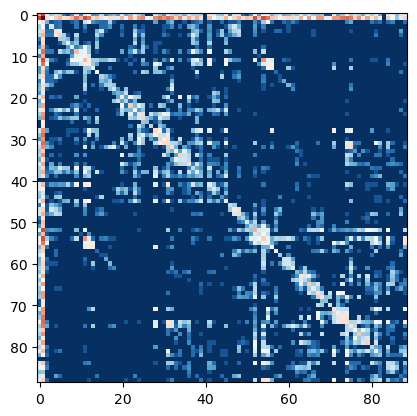

In [56]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(np.log1p(M), interpolation='nearest', cmap='RdBu_r') 

In [75]:
##### the first 3 rows and colums are L WM , R WM and white matter intensities so we remove them.

M_copy = M.copy()

In [76]:
M_copy[:3, :] = 0
M_copy[:, :3] = 0

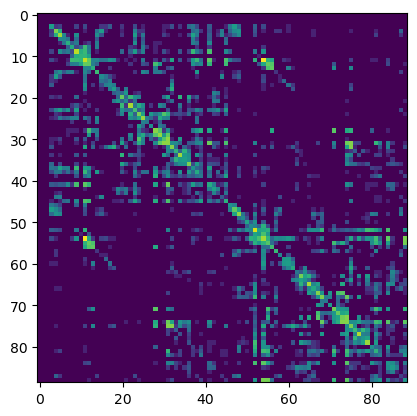

In [77]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(np.log1p(M_copy), interpolation='nearest') 

In [86]:
np.log1p(M_copy)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.69314718, 0.        ,
        1.60943791],
       [0.        , 0.        , 0.        , ..., 0.        , 1.38629436,
        0.69314718],
       [0.        , 0.        , 0.        , ..., 1.60943791, 0.69314718,
        3.73766962]])

In [78]:
import pandas as pd

In [90]:
# Mdf = DF = pd.DataFrame(np.log1p(M_copy))

Morigdf = pd.DataFrame(np.log1p(M))

In [80]:
Mdf.to_csv('M_connectivity_EuDx.csv', header=False, index=False)

In [91]:
Morigdf.to_csv('Morig_connectivity_EuDx.csv', header=False, index=False)

In [151]:
##### the first 3 rows and colums are L WM , R WM and white matter intensities so we remove them.

M_copy = M.copy()

In [152]:
M_copy

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0, 8101,  620, ...,    0,    0,    0],
       [   0,  620,   58, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [153]:
lr_superiorfrontal_track = grouping[1, 1]
shape = labels.shape
dm = utils.density_map(lr_superiorfrontal_track, affine, shape)

In [155]:
dm.shape

(81, 106, 76)

In [156]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk

In [158]:
# Save density map
save_nifti("lr-superiorfrontal-EuDx.nii.gz", dm.astype("int16"), affine)

lr_sf_trk = Streamlines(lr_superiorfrontal_track)

# Save streamlines
sft = StatefulTractogram(lr_sf_trk, img, Space.VOX)
save_trk(sft, "lr-superiorfrontal-EuDx.trk")

In [72]:
#### path length

# Make a corpus callosum seed mask for tracking
seed_mask = labels == 2
seeds = utils.seeds_from_mask(seed_mask, affine, density=[1, 1, 1])

# Make a streamline bundle model of the corpus callosum ROI connectivity
streamlines = LocalTracking(csa_peaks, stopping_criterion, seeds, affine, step_size=0.5)
streamlines = Streamlines(streamlines)

In [73]:
streamlines_actor = actor.line(streamlines, cmap.line_colors(streamlines))
surface_opacity = 0.5
surface_color = [0, 1, 1]
seedroi_actor = actor.contour_from_roi(seed_mask, affine,  surface_color, surface_opacity)

scene = window.Scene()
scene.add(streamlines_actor)
scene.add(seedroi_actor)

In [77]:
interactive = True
if interactive:
    window.show(scene)

# window.record(scene, n_frames=1, out_path='plm_roi_sls.png',size=(800, 800))

In [78]:
path_length_map_base_roi = seed_mask

# calculate the WMPL
wmpl = path_length(streamlines, affine, path_length_map_base_roi)

# save the WMPL as a nifti
save_nifti('example_cc_path_length_map_EuDx.nii.gz', wmpl.astype(np.float32), affine)

# get the T1 to show anatomical context of the WMPL
# t1_fname = get_fnames('stanford_t1')
t1_data = load_nifti_data(fit1w)

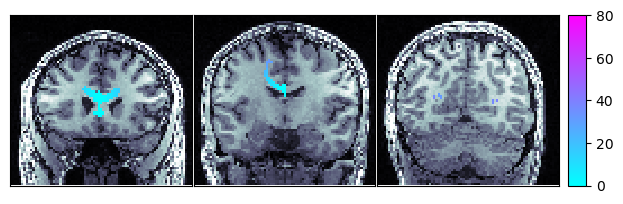

In [79]:
fig = mpl.pyplot.figure()
fig.subplots_adjust(left=0.05, right=0.95)
ax = AxesGrid(fig, 111, nrows_ncols=(1, 3), cbar_location="right", cbar_mode="single", cbar_size="10%", cbar_pad="5%")

wmpl_show = np.ma.masked_where(wmpl < 0, wmpl)

slx, sly, slz = [70, 55, 30]
ax[0].matshow(np.rot90(t1_data[:, slx, :]), cmap=mpl.cm.bone)
im = ax[0].matshow(np.rot90(wmpl_show[:, slx, :]),
                   cmap=mpl.cm.cool, vmin=0, vmax=80)

ax[1].matshow(np.rot90(t1_data[:, sly, :]), cmap=mpl.cm.bone)
im = ax[1].matshow(np.rot90(wmpl_show[:, sly, :]), cmap=mpl.cm.cool,
                   vmin=0, vmax=80)

ax[2].matshow(np.rot90(t1_data[:, slz, :]), cmap=mpl.cm.bone)
im = ax[2].matshow(np.rot90(wmpl_show[:, slz, :]),
                   cmap=mpl.cm.cool, vmin=0, vmax=80)

ax.cbar_axes[0].colorbar(im)
for lax in ax:
    lax.set_xticks([])
    lax.set_yticks([])